In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from sklearn.model_selection import train_test_split

import sys, os
sys.path.append(os.path.abspath("."))   # add current dir
sys.path.append(os.path.abspath(".."))  # add parent dir (if needed)


import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# utils # TODO resolve namespace pollution by restricitn g importis in init
from utils.configuration import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.loss_continous import *
from utils.sampling_tram_data import *



Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "weight_init"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

os.makedirs(EXPERIMENT_DIR,exist_ok=True)
# check if configration dict already exists if not create:

if os.path.exists(CONF_DICT_PATH):
    configuration_dict=load_configuration_dict(CONF_DICT_PATH)
    print(f"Loaded existing configuration from {CONF_DICT_PATH}")
else:
    configuration_dict=create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    print(f"Created new configuration file at {CONF_DICT_PATH}")

Created new configuration file at /home/bule/TramDag/dev_experiment_logs/weight_init/configuration.json


# 2.  Data

         x1        x2  x3        x4  x5
0  0.799968 -0.403072   3  1.242346   1
1  0.236174 -0.299241   1 -0.633190   1
2  0.732982 -0.563851   3  1.412221   1
3  0.402303 -0.174495   2  0.379400   0
4  0.226585 -0.291049   3  1.762330   1


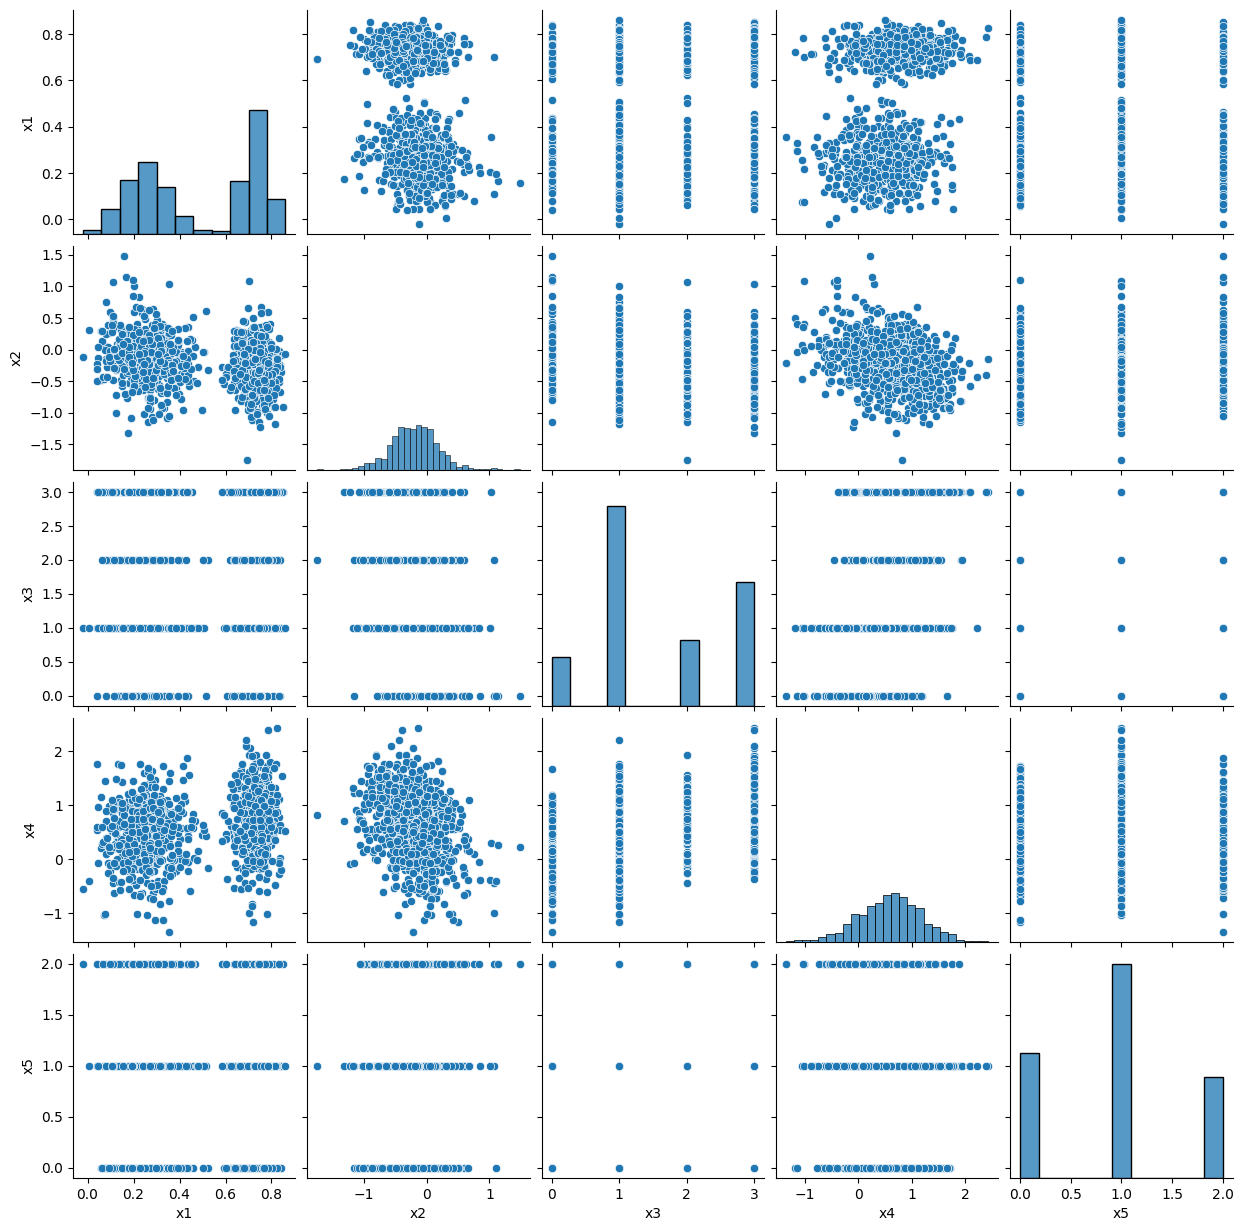

In [3]:

def dgp(n_obs, doX=[None, None, None, None, None], f=lambda x: x, seed=None):
    """
    Data-generating process with 5 variables:
      - x1, x2, x4: continuous
      - x3: ordered categorical with levels [0,1,2,3]
      - x5: nominal categorical with levels [0,1,2]

    Parameters
    ----------
    n_obs : int
        Number of observations.
    doX : list of length 5
        Fix values for x1..x5 (use None for random sampling).
    f : callable
        Function of x2 used in generating x3.
    seed : int or None
        Random seed.

    Returns
    -------
    pd.DataFrame
        Columns ['x1','x2','x3','x4','x5']
    """
    if seed is not None:
        np.random.seed(seed)

    # --- x1: GMM ---
    if doX[0] is None:
        X1_A = np.random.normal(loc=0.25, scale=0.10, size=n_obs)
        X1_B = np.random.normal(loc=0.73, scale=0.05, size=n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, X1_A, X1_B)
    else:
        x1 = np.full(n_obs, doX[0], dtype=float)

    # --- x2: shifted-logit ---
    if doX[1] is None:
        u2 = np.random.uniform(size=n_obs)
        z2 = np.log(u2 / (1 - u2))
        x2 = (z2 - 2 * x1) / 5.0
    else:
        x2 = np.full(n_obs, doX[1], dtype=float)

    # --- x3: ordered categorical ---
    if doX[2] is None:
        u3 = np.random.logistic(loc=0.0, scale=1.0, size=n_obs)
        theta = np.array([-2.0, 0.42, 1.02])
        h = theta + 0.2 * x1.reshape(-1, 1) + f(x2).reshape(-1, 1)
        x3 = np.zeros(n_obs, dtype=int)
        x3[u3 > h[:, 0]] = 1
        x3[u3 > h[:, 1]] = 2
        x3[u3 > h[:, 2]] = 3
    else:
        x3 = np.full(n_obs, int(doX[2]), dtype=int)

    # --- x4: continuous depending on x1,x2,x3 ---
    if doX[3] is None:
        mu4 = 0.5 * x1 - 0.3 * x2 + 0.2 * x3
        x4 = np.random.normal(loc=mu4, scale=0.5, size=n_obs)
    else:
        x4 = np.full(n_obs, doX[3], dtype=float)

    # --- x5: nominal categorical with 3 classes (0,1,2) ---
    if doX[4] is None:
        logits = np.zeros((n_obs, 3))
        logits[:, 1] = -0.2 + 0.8 * x1 + 0.2 * x2 + 0.3 * x4 + 0.15 * x3
        logits[:, 2] = 0.1 - 0.5 * x1 + 0.6 * x2 - 0.2 * x4 + 0.10 * x3
        exp_logits = np.exp(logits - logits.max(axis=1, keepdims=True))
        probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
        draws = [np.random.choice([0, 1, 2], p=p) for p in probs]
        x5 = np.array(draws, dtype=int)
    else:
        x5 = np.full(n_obs, int(doX[4]), dtype=int)

    return pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'x5': x5})


EXP_DATA_PATH=os.path.join(DATA_PATH, f"{experiment_name}.csv")
if not os.path.exists(EXP_DATA_PATH):
    df = dgp(n_obs=1000, seed=42)
    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)
else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")

sns.pairplot(df)

In [4]:
data_type= {'x1':'continous','x2':'continous'}

write_data_type_to_configuration(data_type, CONF_DICT_PATH)

df.info()

Variable 'x1' is modeled as a continuous variable. for target and predictor.
Variable 'x2' is modeled as a continuous variable. for target and predictor.
Configuration updated successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1000 non-null   float64
 1   x2      1000 non-null   float64
 2   x3      1000 non-null   int64  
 3   x4      1000 non-null   float64
 4   x5      1000 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 39.2 KB


## 2.1 train test split

In [5]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

# # 3. Normalize all sets using training quantiles
# def normalize_with_quantiles(df, min_vals, max_vals):
#     return (df - min_vals) / (max_vals - min_vals)


# def normalize_with_quantiles(df, min_vals, max_vals, exclude_columns=None):
#     """
#     Normalize df using (df - min) / (max - min), but skip any columns in exclude_columns.
#     min_vals and max_vals should come from the training set.
#     """
#     exclude_columns = set() if exclude_columns is None else set(exclude_columns)
#     normalized = df.copy()

#     for col in df.columns:
#         if col in exclude_columns:
#             continue
#         if col not in min_vals.index or col not in max_vals.index:
#             continue
#         min_val = min_vals[col]
#         max_val = max_vals[col]
#         range_ = max_val - min_val
#         if range_ == 0 or pd.isna(range_):
#             normalized[col] = df[col].apply(lambda x: 0.0 if not pd.isna(x) else x)
#         else:
#             normalized[col] = (df[col] - min_val) / range_
#     return normalized


# train_df = normalize_with_quantiles(train_df, min_vals, max_vals,exclude_columns=['x3'])
# val_df = normalize_with_quantiles(val_df, min_vals, max_vals,exclude_columns=['x3'])
# test_df = normalize_with_quantiles(test_df, min_vals, max_vals,exclude_columns=['x3'])



print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 800, Validation size: 100, Test size: 100


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


In [6]:
interactive_adj_matrix(CONF_DICT_PATH,seed=10)

No matrix found. Please fill out the DAG and click 'Generate'.


# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

In [8]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [9]:
levels_dict=create_levels_dict(df,data_type)

write_nodes_information_to_configuration(CONF_DICT_PATH, min_vals, max_vals,levels_dict)

{'x1': {'Modelnr': 0, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'min': 0.12854786353531034, 'max': 0.7945505419528904, 'batch_size': 512, 'epochs': 100, 'learning_rate': 0.01, 'use_scheduler': False, 'transformation_term_nn_models_in_h()': {}}, 'x2': {'Modelnr': 1, 'data_type': 'continous', 'node_type': 'sink', 'parents': ['x1'], 'parents_datatype': {'x1': 'continous'}, 'transformation_terms_in_h()': {'x1': np.str_('ls')}, 'min': -0.809538789812, 'max': 0.36504416874660905, 'batch_size': 512, 'epochs': 100, 'learning_rate': 0.01, 'use_scheduler': False, 'transformation_term_nn_models_in_h()': {'x1': np.str_('LinearShift')}}}
Configuration updated successfully.


### --------------------- 

# Training

In [10]:
# hyperparams:
train_list=['x1']#,'x2']#<-  set the nodes which have to be trained , useful if further training is required else lsit all vars
configuration_dict = load_configuration_dict(CONF_DICT_PATH)

# if you change the hyperparams -> write them to the config file!

In [11]:
# For each NODE 
node_list = configuration_dict['nodes'] ## TODO rename target nodes to nodelist 

for node in node_list:
    
    ########################## 0. Get hyperparameters ###############################
    batch_size, epochs, learning_rate, use_scheduler = get_hyperparameters_for_node(node,node_list)
    
    ############ Edited hyperparameters ##########
    batch_size = 512
    epochs = 100
    learning_rate = 0.01
    use_scheduler = False
    
    
    print(f"Using hyperparameters: batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}, use_scheduler={use_scheduler}")

    
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')
    ########################## 1. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (node_list[node]['node_type'] == 'source') and (node_list[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 2. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    

    ########################## 3. Check if training is complete ###############################
    if not check_if_training_complete(node, NODE_DIR, epochs):
        continue
    
    ########################## 4. Create Model ##############################
    tram_model= get_fully_specified_tram_model(node, node_list, verbose=True, set_initial_weights=True)
    
    
    
        # access the last linear layer in nn_int
    last_linear = tram_model.nn_int.fc  

    # get the weights
    weights = last_linear.weight.data  # tensor
    weights_numpy = last_linear.weight.detach().cpu().numpy()  # numpy array if you prefer

    print("Weights tensor:\n", weights)
    print("Weights shape:", weights.shape)
    
    

    ########################## 5. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, node_list, train_df, val_df, batch_size=batch_size,return_intercept_shift=True, verbose=False)

    ########################## 6. Optimizer & Scheduler ######################.
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 7. Training Loop ##############################
    
    train_val_loop(
                node,
                node_list,
                NODE_DIR,
                tram_model,
                train_loader,
                val_loader,
                epochs,
                optimizer,
                use_scheduler,
                scheduler,
                save_linear_shifts=False,
                verbose=1,
                device=device,
                debug=False) # TODO startvalues for bernsteinpols


Using hyperparameters: batch_size=512, epochs=100, learning_rate=0.01, use_scheduler=False

----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
Initialized intercept model with increasing weights: SimpleIntercept(
  (fc): Linear(in_features=1, out_features=20, bias=False)
)
Weights tensor:
 tensor([[-3.0000],
        [-2.6842],
        [-2.3684],
        [-2.0526],
        [-1.7368],
        [-1.4211],
        [-1.1053],
        [-0.7895],
        [-0.4737],
        [-0.1579],
        [ 0.1579],
        [ 0.4737],
        [ 0.7895],
        [ 1.1053],
        [ 1.4211],
        [ 1.7368],
        [ 2.0526],
        [ 2.3684],
        [ 2.6842],
        [ 3.0000]])
Weights shape: torch.Size([20, 1])
No existing model found. Starting fresh...
Saved new best model.
Epoch 1/100  Train NLL: 1.3793  Val NLL: 1.2904  [Train: 0.63s  Val: 0.20s  Total: 0.83s]
Saved new best model.
Epoch 2/100  Train NLL: 1.3810  Val NLL: 1.2790  [Train: 0

In [12]:
# access the last linear layer in nn_int
last_linear = tram_model.nn_int.fc  

# get the weights
weights = last_linear.weight.data  # tensor
weights_numpy = last_linear.weight.detach().cpu().numpy()  # numpy array if you prefer

print("Weights tensor:\n", weights)
print("Weights shape:", weights.shape)


Weights tensor:
 tensor([[-4.6485],
        [-0.7506],
        [-0.4352],
        [-0.1312],
        [ 0.1594],
        [ 0.4362],
        [ 0.7011],
        [ 0.9537],
        [ 1.1865],
        [ 1.3730],
        [ 1.4285],
        [ 1.0836],
        [ 0.3135],
        [ 0.4641],
        [ 2.0540],
        [ 3.1581],
        [ 3.6881],
        [ 4.0796],
        [ 4.4294],
        [ 4.7723]], device='cuda:0')
Weights shape: torch.Size([20, 1])


# 6 Inspect Training

## 6.1 Loss vs epochs

No history found for node: x2


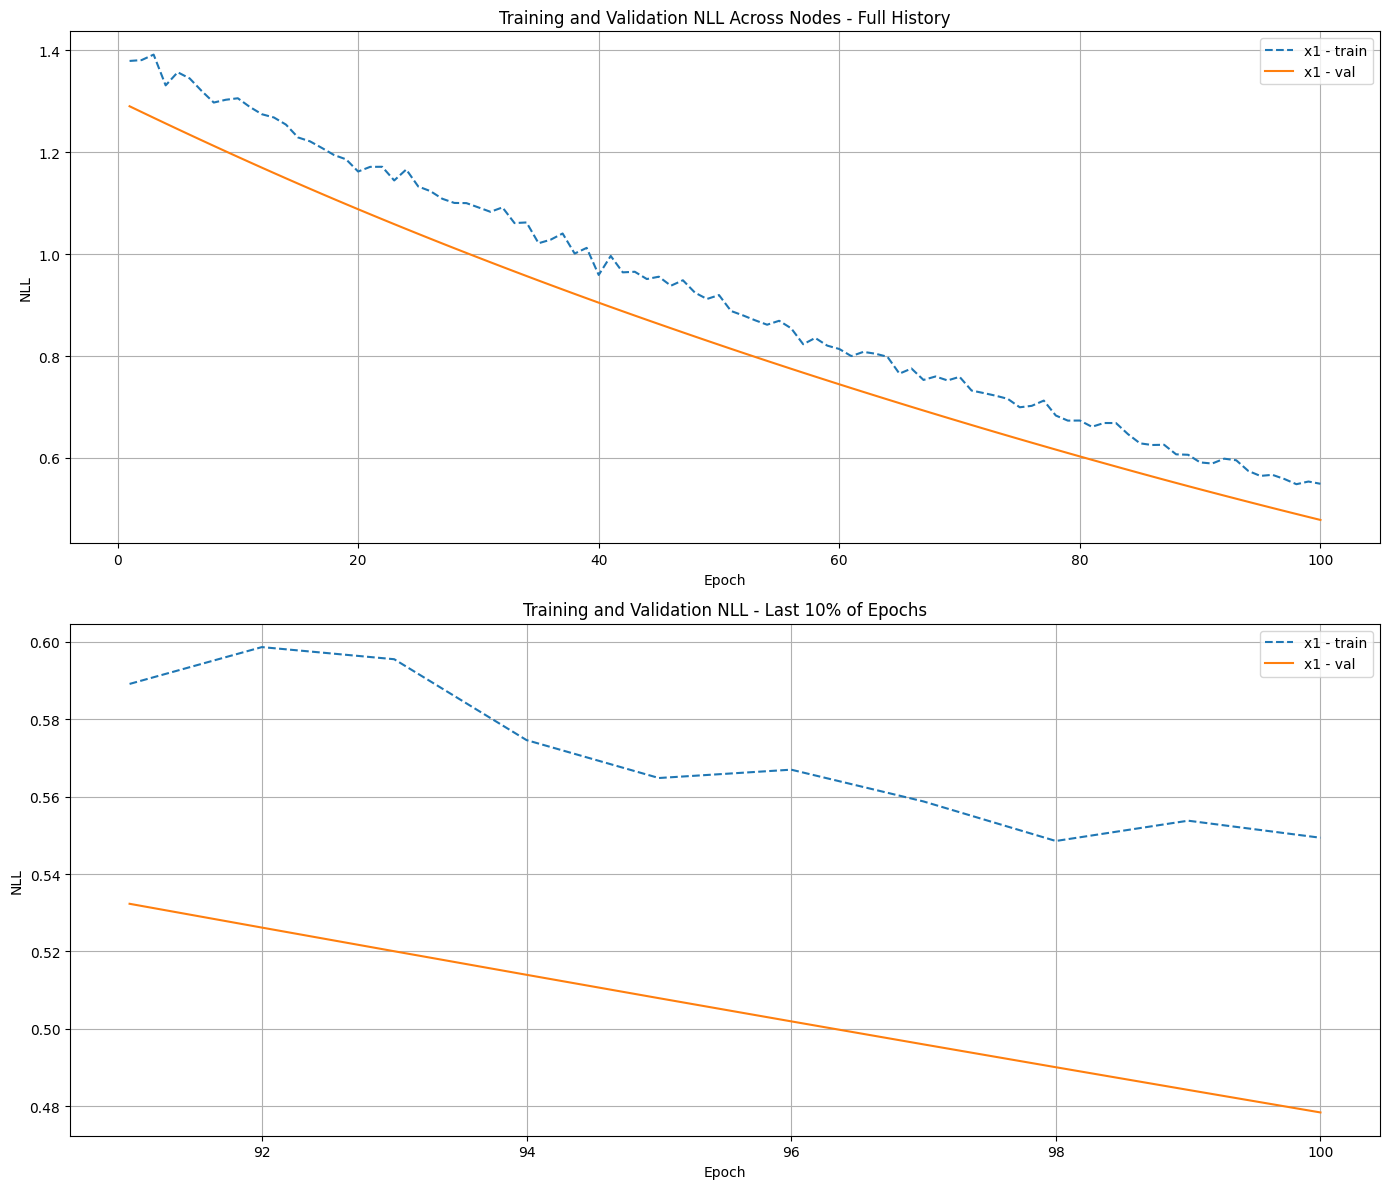

In [13]:
show_training_history(node_list,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--
[WARNING] target_col 'x1' not in DataFrame columns — is this intended for use as a Sampler?


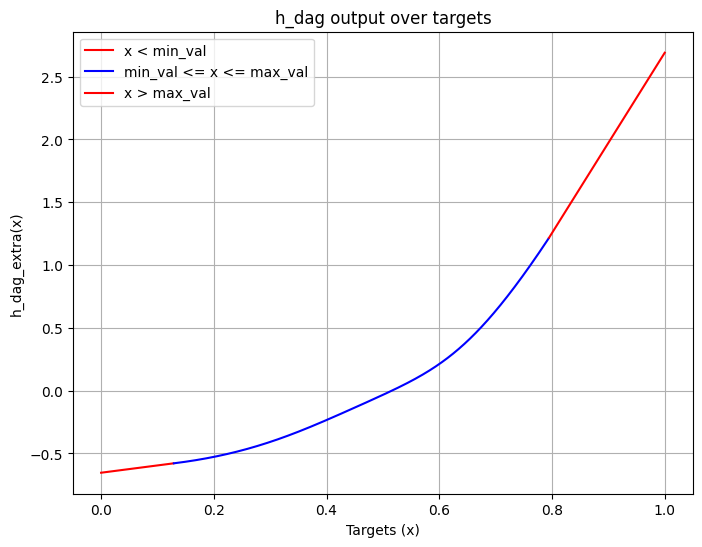


----*----------*-------------*--------Inspect TRAFO Node: x2 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance


In [14]:
show_hdag_for_source_nodes(node_list,EXPERIMENT_DIR,device,xmin_plot=-0,xmax_plot=1)

----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


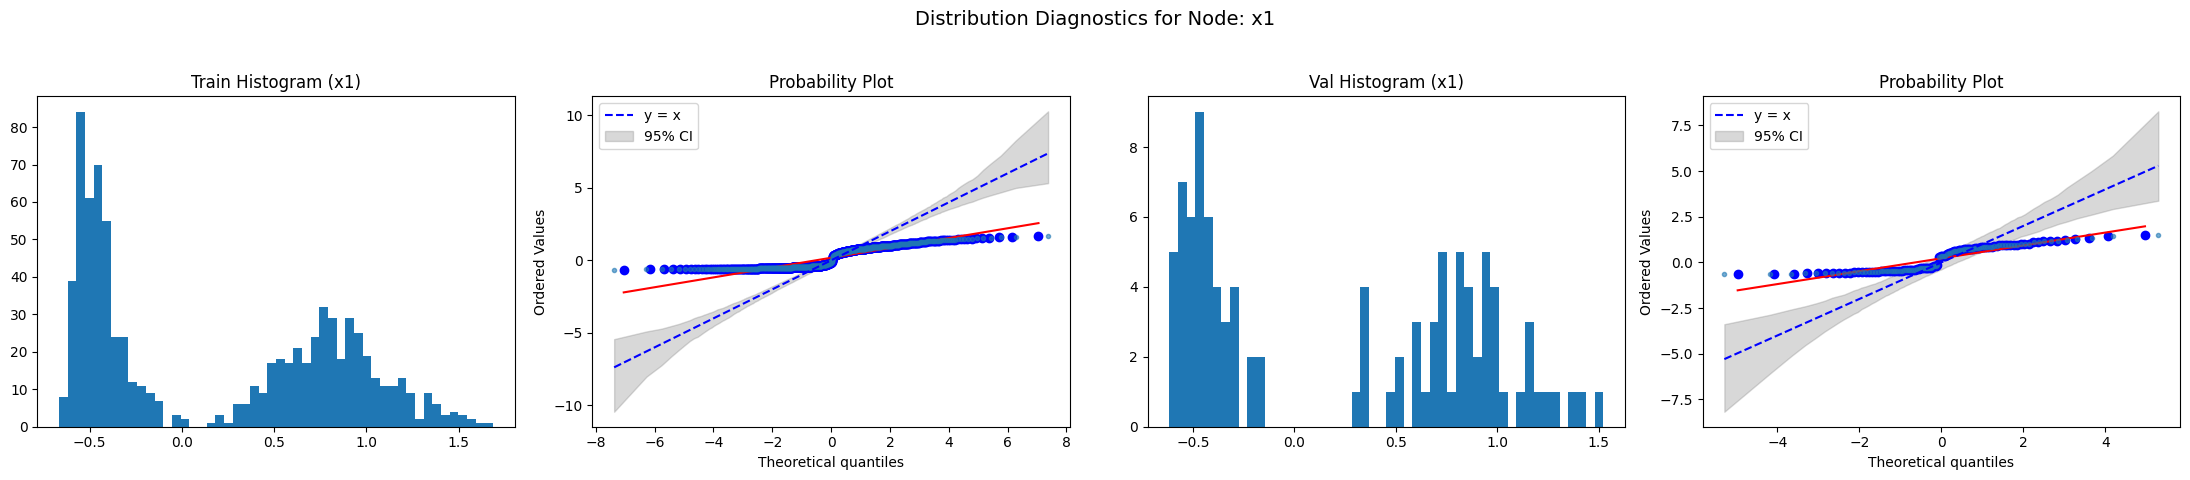

----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


FileNotFoundError: [Errno 2] No such file or directory: '/home/bule/TramDag/dev_experiment_logs/weight_init/x2/best_model.pt'

In [15]:
inspect_trafo_standart_logistic(node_list, EXPERIMENT_DIR, train_df, val_df, device, verbose=False)

# 7. Sample from Graph

In [ ]:
sample_full_dag(node_list,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={},
                            number_of_samples= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True,
                            debug=True)

## 7.3 Inspect Sampling

In [ ]:
show_samples_vs_true(train_df,node_list,EXPERIMENT_DIR)

## 7.4 Intervention

In [ ]:
def f(x):
    return -0.3*x  

intervention_df=dgp(10_000, doX=[-1.0, None, None], seed=-1)
sns.pairplot(intervention_df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
sample_full_dag_chandru(node_list,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={'x1':-1.0},
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True)

In [ ]:
show_samples_vs_true(intervention_df,node_list,EXPERIMENT_DIR,rootfinder='chandrupatla')